<a href="https://colab.research.google.com/github/cesarofuchi/pyuvp/blob/master/test_pyuvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pyuvp water flow example

In this example we present how to use the ultrasound and ultrasound_doppler modules in a water flow pipeline context. Some details of this experiment:
* Mean velocity of ~ 0.5 m/s measured by a Coriolis flowmeter was used. 
* Seeding of plastic particles ~200um
* fc = 4MHz transducer central frequency
* fprf = 1000 pulse repetition frequency
* fs = 50 MSamples/s (sampling rate)

We will present the autocorrelation and extended autocorrelation within a flow over the Nyquist maximum measurable velocity limit.


## 1. Download the ultrasonic example files

Please download the file `liquid_velocity_05_fprf1000.pickle` from this repository:
https://nuvem.utfpr.edu.br/index.php/s/Mr5G2JVdMD3FJL6

<----Drag the file into the Google Colab file directory 


## 2. Installation and imports


In [1]:
!pip install pyuvp
!pip3 install pickle5
import pickle5 as pickle
import pyuvp.ultrasound as us
import pyuvp.ultrasound_doppler as usd
import matplotlib.pyplot as plt
from scipy.signal import medfilt2d,lfilter,hilbert
import math
import numpy as np

     |████████████████████████████████| 133kB 4.0MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219277 sha256=d65ef8cd0fa8271edd12e4654018923cf2f863e1a5cdc6f24cb2d1cc5ff966aa
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


After you downloaded the files let's open the velocity data

In [3]:
with open('/content/liquid_velocity_05_fprf1000.pickle', 'rb') as f:
    velocity_data = pickle.load(f)

## Creating ultrasonic object

In [4]:
fs=50e6
fc=4e6
fprf=1000
samples=5000
nwaves, samples= velocity_data.shape
usObj=us.Ultrasound(fs,fc,fprf,samples,nwaves,velocity_data)

## Evaluate Ultrasonic Raw Data
Let's see the ultrasonic raw data with A-scan and B-scan plots

Text(0.5, 1.0, 'A scan')

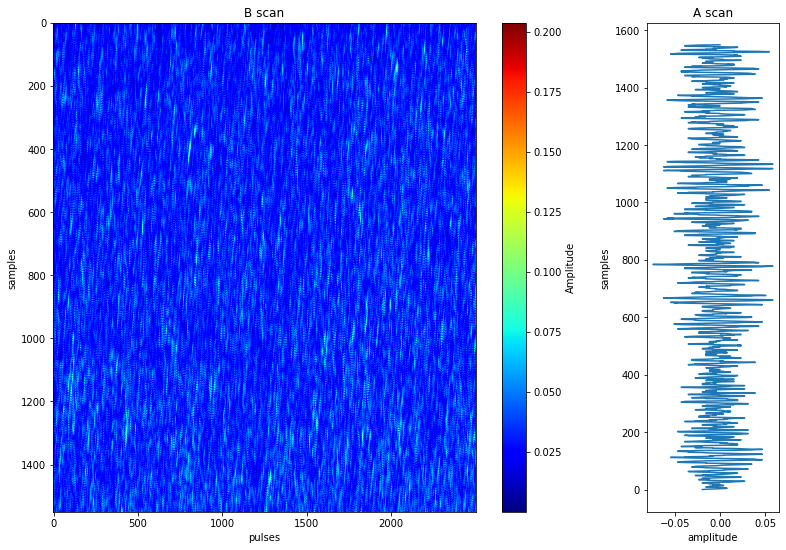

In [21]:
# A Scan
fig, ax=plt.subplots(1,2,figsize=(13, 9),gridspec_kw={'width_ratios': [4, 1]})
cm = plt.cm.get_cmap("jet")
sc=ax[0].imshow(abs(hilbert(velocity_data)),cmap=cm,aspect='auto')
fig.colorbar(sc, ax=ax[0], orientation="vertical", label='Amplitude')

ax[0].set_title('B scan')
ax[0].set_ylabel('samples')
ax[0].set_xlabel('pulses')



x=np.arange(0,velocity_data.shape[0],1)
ax[1].plot(velocity_data[:,1],x)
ax[1].set_xlabel('amplitude')
ax[1].set_ylabel('samples')
ax[1].set_title('A scan')

## Evaluate Velocity Profile

In [6]:
#sound speed at water 
c=1490
vmax=c*usObj.fprf/(4*usObj.fc)
ns=50;nc=50;ovs=1;ovt=1;
usdObj=usd.UltrasoundDoppler(usObj,ns,nc,ovs,ovt)
angle=10
print('c=',c,'m/s fprf=',usObj.fprf)
print('max measurable velocity=',vmax/math.sin(math.radians(angle)),'m/s')

c= 1490 m/s fprf= 1000
max measurable velocity= 0.5362855012427509 m/s


### Classic Autocorrelation Method (ACM)

We will test the autocorrelation method to see if it works in this context. Without knowledge of the flow behaviour, we could think that the velocity is measurable as 0.5 m/s < max measurable velocity

In [7]:
flow,t=usdObj.auto_correlation(c)
flow_corrected=flow/math.sin(math.radians(angle)) 
#med filter for smoothing
flowfilt=medfilt2d(flow_corrected, [3, 3])
vmean=flowfilt.mean(axis=1)
print('mean flow:',np.mean(abs(vmean)),' total time:',t)

mean flow: 0.29045961852521324  total time: 0.16406726837158203


### Plot velocity map

Text(0.5, 1.0, 'Mean Velocity Profile')

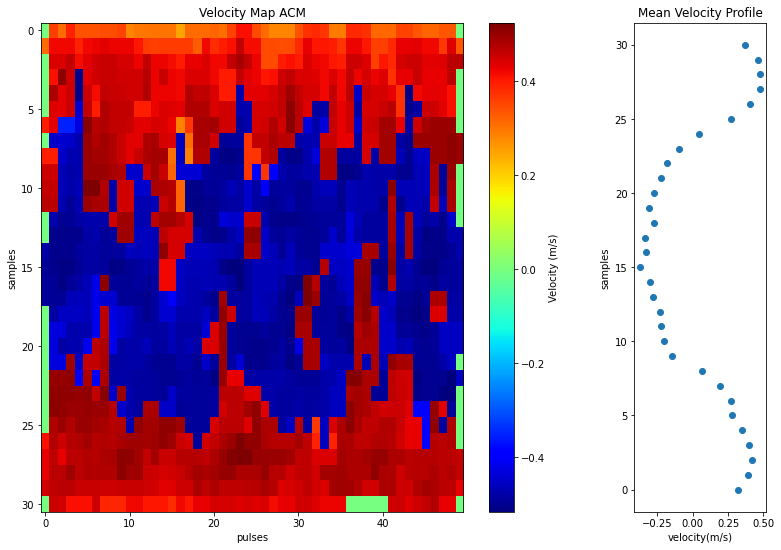

In [31]:
fig, ax=plt.subplots(1,2,figsize=(13, 9),gridspec_kw={'width_ratios': [4, 1]})
cm = plt.cm.get_cmap("jet")
sc=ax[0].imshow(-flowfilt,cmap=cm,aspect='auto')
ax[0].set_title('Velocity Map ACM')
ax[0].set_ylabel('samples')
ax[0].set_xlabel('pulses')
fig.colorbar(sc, ax=ax[0], orientation="vertical", label='Velocity (m/s)')
x=np.arange(0,flowfilt.shape[0],1)
ax[1].scatter(-np.mean(flowfilt,axis=1),x)
ax[1].set_xlabel('velocity(m/s)')
ax[1].set_ylabel('samples')
ax[1].set_title('Mean Velocity Profile')

As we can see, we have aliasing problem as the flow profile have some points over the max measurable limit.

## Extended Autocorrelation (EAM)

In [26]:
# extended autocorrelation
flow,t=usdObj.auto_correlation(c,method='extended')
flow_corrected=flow/math.sin(math.radians(angle)) 
#med filter for smoothing
flowfilt_ex=medfilt2d(flow_corrected, [3, 3])
vmean=flowfilt_ex.mean(axis=1)
print('mean flow:',np.mean(abs(vmean)),' total time:',t)

mean flow: 0.5124544037333362  total time: 2.5585711002349854


Text(0.5, 1.0, 'Mean Velocity Profile')

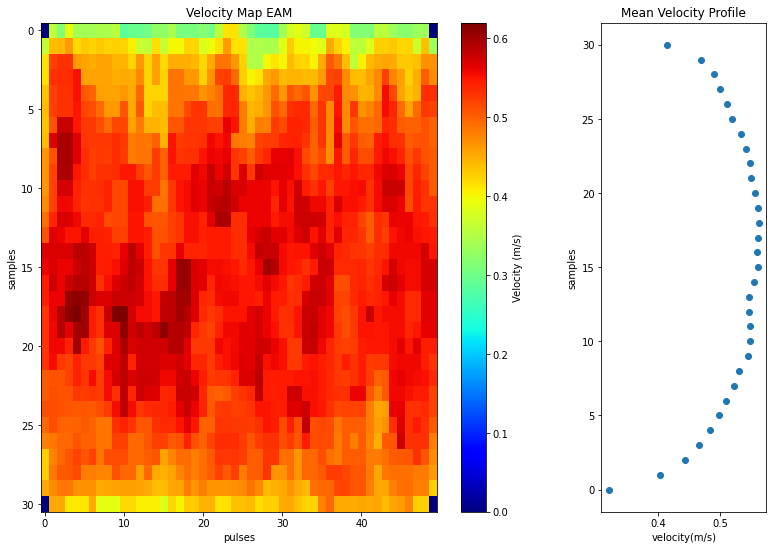

In [32]:

fig, ax=plt.subplots(1,2,figsize=(13, 9),gridspec_kw={'width_ratios': [3, 1]})
cm = plt.cm.get_cmap("jet")
sc=ax[0].imshow(-flowfilt_ex,cmap=cm,aspect='auto')
ax[0].set_title('Velocity Map EAM')
ax[0].set_ylabel('samples')
ax[0].set_xlabel('pulses')
fig.colorbar(sc, ax=ax[0], orientation="vertical", label='Velocity (m/s)')
x=np.arange(0,flowfilt_ex.shape[0],1)
ax[1].scatter(-np.mean(flowfilt_ex,axis=1),x)
ax[1].set_xlabel('velocity(m/s)')
ax[1].set_ylabel('samples')
ax[1].set_title('Mean Velocity Profile')

It works! Although we have a processing time penalty, now we can measure velocities over Nyquist limit